In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import confusion_matrix, classification_report

# Add the 'src' directory to the path so we can import modules if needed
# This ensures it finds your 'src' folder regardless of where the notebook is running
sys.path.append(os.path.abspath('../src'))

# Set plot style for prettier graphs
sns.set(style="whitegrid")
%matplotlib inline

print("VS Code Environment Setup Complete.")

VS Code Environment Setup Complete.


Dataset loaded successfully: 50000 rows


C:\Users\28rac\AppData\Local\Temp\ipykernel_30692\150354520.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


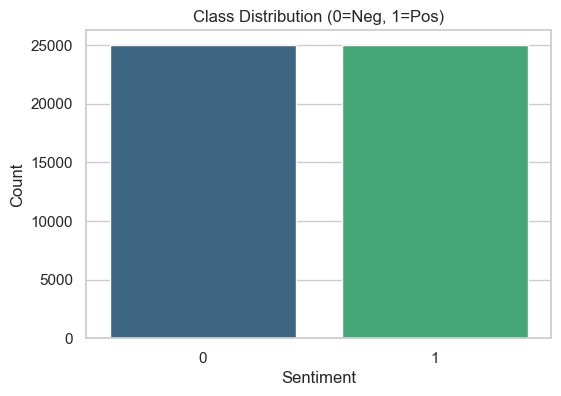

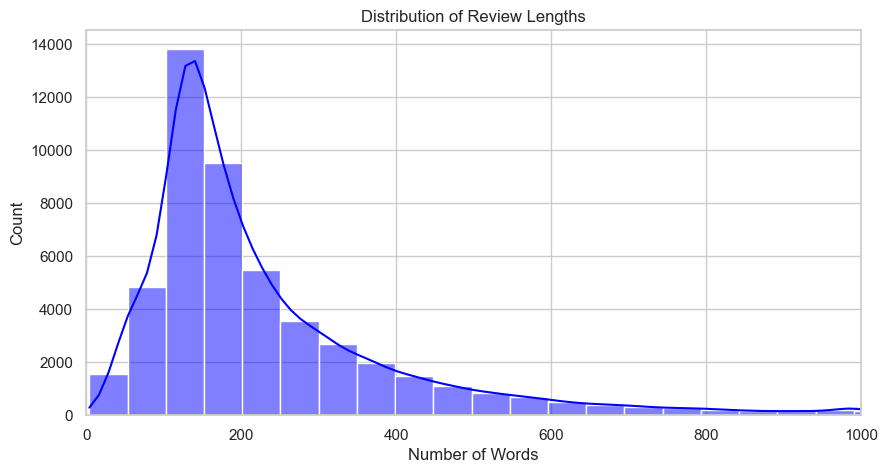

In [7]:
# Load the dataset prepared by src/preprocess.py
data_path = "../data/imdb.csv"

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully: {df.shape[0]} rows")
    
    # --- Plot 1: Class Distribution ---
    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=df, palette='viridis')
    plt.title("Class Distribution (0=Neg, 1=Pos)")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

    # --- Plot 2: Review Lengths ---
    # Calculate length (number of words)
    df['review_length'] = df['text'].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(10, 5))
    sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
    plt.title("Distribution of Review Lengths")
    plt.xlabel("Number of Words")
    plt.xlim(0, 1000)
    plt.show()
else:
    print("Error: data/imdb.csv not found. Please run 'python src/preprocess.py' in your terminal first.")

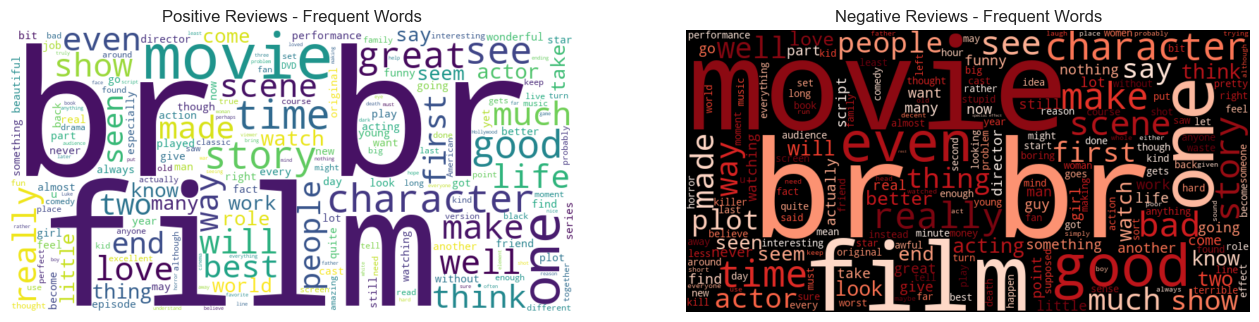

In [8]:
# Filter positive and negative reviews
pos_text = " ".join(df[df['label'] == 1]['text'].head(1000).astype(str))
neg_text = " ".join(df[df['label'] == 0]['text'].head(1000).astype(str))

# Generate Clouds
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(neg_text)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(wc_pos, interpolation='bilinear')
axes[0].set_title("Positive Reviews - Frequent Words")
axes[0].axis('off')

axes[1].imshow(wc_neg, interpolation='bilinear')
axes[1].set_title("Negative Reviews - Frequent Words")
axes[1].axis('off')

plt.show()

Classical model artifacts missing.
Transformer model missing.


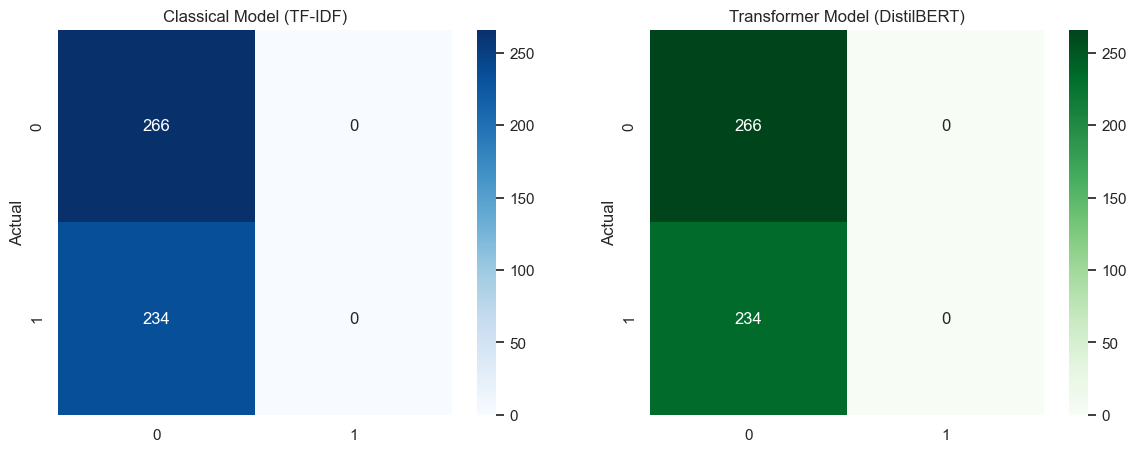


--- Classical Classification Report ---

              precision    recall  f1-score   support

           0       0.53      1.00      0.69       266
           1       0.00      0.00      0.00       234

    accuracy                           0.53       500
   macro avg       0.27      0.50      0.35       500
weighted avg       0.28      0.53      0.37       500



c:\Users\28rac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\28rac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\28rac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [9]:
# Load a small test set for evaluation
test_subset = df[df['split'] == 'test'].sample(500, random_state=42)
y_true = test_subset['label'].values
texts = test_subset['text'].tolist()

# --- 1. Classical Model (TF-IDF) ---
tfidf_path = "../models/saved_model/tfidf_vectorizer.pkl"
logreg_path = "../models/saved_model/logreg_model.pkl"

if os.path.exists(tfidf_path):
    tfidf = joblib.load(tfidf_path)
    logreg = joblib.load(logreg_path)
    X_test_tfidf = tfidf.transform(texts)
    y_pred_classic = logreg.predict(X_test_tfidf)
    print("Classical model evaluated.")
else:
    print("Classical model artifacts missing.")
    y_pred_classic = np.zeros(len(y_true))

# --- 2. Transformer Model (DistilBERT) ---
bert_path = "../models/saved_model/distilbert_sentiment"

if os.path.exists(bert_path):
    print("Loading Transformer model (this may take a moment)...")
    classifier = pipeline("sentiment-analysis", model=bert_path, tokenizer=bert_path, truncation=True, max_length=512, device=-1)
    
    # Get predictions
    bert_preds = classifier(texts)
    y_pred_bert = [1 if p['label'] == 'LABEL_1' else 0 for p in bert_preds]
    print("Transformer model evaluated.")
else:
    print("Transformer model missing.")
    y_pred_bert = np.zeros(len(y_true))

# --- 3. Compare Results ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Classical
sns.heatmap(confusion_matrix(y_true, y_pred_classic), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Classical Model (TF-IDF)")
ax[0].set_ylabel("Actual")

# Plot Transformer
sns.heatmap(confusion_matrix(y_true, y_pred_bert), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("Transformer Model (DistilBERT)")
ax[1].set_ylabel("Actual")

plt.show()

# Print text report
print("\n--- Classical Classification Report ---\n")
print(classification_report(y_true, y_pred_classic))